# Implementation of Multilayer Perceptrons (MLP)

## Giới thiệu về Multilayer Perceptrons (MLP)

Multilayer Perceptrons (MLP) là một loại mạng nơ-ron nhân tạo bao gồm nhiều lớp, bao gồm lớp đầu vào, các lớp ẩn và lớp đầu ra. MLP có khả năng học các biểu diễn phi tuyến tính của dữ liệu, làm cho chúng phù hợp với các nhiệm vụ như phân loại và hồi quy. Đây là một trong những mô hình cơ bản của học sâu, được xây dựng dựa trên các nơ-ron kết nối đầy đủ giữa các lớp.

## Implementation

Trong phần này, chúng ta implement một MLP đơn giản bằng Python và NumPy. MLP bao gồm một lớp ẩn với hàm kích hoạt ReLU và lớp đầu ra với hàm softmax cho nhiệm vụ phân loại.

In [ ]:
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

### Khởi tạo tham số

Khởi tạo các ma trận trọng số và vector bias:
*   Hai ma trận trọng số W1 (784×256) và W2 (256×10), cùng hai vector bias b1 và b2
*   W1: Ma trận trọng số kết nối lớp đầu vào (input layer) với lớp ẩn (hidden layer)
*   W2: Ma trận trọng số kết nối lớp ẩn với lớp đầu ra (output layer).
*   W1 và W2 được khởi tạo ngẫu nhiên (Tránh sự đối xứng: Nếu tất cả trọng số giống nhau, các neuron sẽ học giống nhau → Mạng không hiệu quả) với phân phối chuẩn (Gaussian) với mean = 0, variance = 1 (np.random.randn). Nhân với sigma để kiểm soát phương sai (tránh gradient quá lớnlớn - Exploding Gradient hoặc quá nhỏ - Vanishing gradient)
*   b1: Vector bias cho lớp ẩn, giúp mô hình linh hoạt hơn bằng cách dịch chuyển đầu ra.
*   b2: Vector bias cho lớp đầu ra, giúp điều chỉnh giá trị đầu ra cuối cùng.
*   b1, b2 thường được khởi tạo bằng 0 để đảm bảo tính đối xứng ban đầu. Đôi khi có thể khởi tạo giá trị nhỏ (ví dụ: 0.01) để tránh Dying ReLU khi dùng ReLU.

In [ ]:
batch_size      = 256
learning_rate   = 0.1
num_epochs      = 10

def init_params(num_inputs, num_hiddens, num_outputs, sigma=0.01):
    params = {
        'W1': np.random.randn(num_inputs, num_hiddens) * sigma,
        'b1': np.zeros((1, num_hiddens)),
        'W2': np.random.randn(num_hiddens, num_outputs) * sigma,
        'b2': np.zeros((1, num_outputs)),
    }
    return params, num_inputs

### Hàm kích hoạt ReLU
ReLU (Rectified Linear Unit) là hàm kích hoạt phi tuyến được sử dụng phổ biến nhất trong các mạng neural sâu (Deep Neural Networks). Nó giúp giải quyết vấn đề vanishing gradient và tăng tốc độ hội tụ của mô hình.
$$\operatorname{ReLU}(z) = \max(z, 0).$$
*   Đơn giản, tính toán nhanh. Chỉ cần so sánh và gán giá trị, không cần phép toán phức tạp như sigmoid/tanh
*   Giảm thiểu vanishing gradient (Đạo hàm = 1 khi x > 0, giữ gradient không bị suy giảm qua các lớp.) so với sigmoid/tanh

In [ ]:
def relu(Z):
    return np.maximum(0, Z)

### Softmax cho đầu ra logits
$$\hat{\mathbf{y}} = \mathrm{softmax}(\mathbf{z}) \quad \textrm{where}\quad \hat{y}_i = \frac{\exp(z_i)}{\sum_j \exp(z_j)}.$$
Biến đầu ra thô (logits) từ lớp cuối cùng (Z) thành phân phối xác suất với các giá trị nằm trong khoảng [0, 1] và tổng = 1. \
Trong thực tế ta dùng `np.exp(Z - np.max(Z, axis=1, keepdims=True))` mà không dùng `np.exp(Z)` để ngăn chặn tràn số khi giá trị trong Z quá lớn. Việc trừ đi giá trị cực đại trên mỗi dòng (hoặc mỗi vector logits) không làm thay đổi kết quả cuối cùng của Softmax về mặt toán học nhưng giúp các giá trị đầu vào cho hàm mũ luôn ≤ 0, từ đó giới hạn kết quả của np.exp trong khoảng
(0,1]và đảm bảo tính ổn định số học

In [ ]:
def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=1, keepdims=True))
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

### Lan truyền thuận Forward Propagation

Tính toán đầu ra của mạng:
*   Lớp ẩn
$$Z_1 = XW_1 + b_1$$
Z1: ma trận của lớp ẩn  
X: ma trận 2D chứa dữ liệu ảnh đã được flatten từ tensor batch X_train \
W1: ma trận trọng số lớp ẩn \
b1: Bias lớp ẩn
$$\quad A_1 = \mathrm{ReLU}(Z_1)$$
A1: ma trận được tạo bởi hàm kích hoạt ReLU
*   Lớp đầu ra (logits)
$$Z_2 = A_1W_2 + b_2$$
Z2: ma trận của đầu ra  
A1: ma trận được tạo bởi hàm kích hoạt ReLU \
W2: ma trận trọng số lớp đầu ra \
b1: Bias lớp đầu ra
$$\quad \hat Y = \mathrm{Softmax}(Z_2)$$

In [ ]:
def forward_propagation(X, params):
    W1, b1, W2, b2 = params['W1'], params['b1'], params['W2'], params['b2']
    # Lớp ẩn
    Z1 = X.dot(W1) + b1
    A1 = relu(Z1)                    # kích hoạt
    # Lớp đầu ra
    Z2 = A1.dot(W2) + b2
    Y_hat = softmax(Z2)              # xác suất dự đoán
    return Z1, A1, Z2, Y_hat

### Hàm mất mát cross-entropy
Tính loss trung bình của Cross-Entropy và gradient
*   cross-entropy loss
$$ l(\mathbf{y}, \hat{\mathbf{y}})_{sum} = - \sum_{j=1}^m y_j \log \hat{y}_j. $$
*   cross-entropy trung bình, tránh cho giá trị loss tăng tỷ lệ thuận với m (số mẫu của bach) khiến cho giá trị loss của bacth có size lớn khác với batch có size nhỏ
$$ l(\mathbf{y}, \hat{\mathbf{y}})_{mean} = -  \frac{1}{m}\sum_{j=1}^m y_j \log \hat{y}_j. $$
*   Gradient
$$
\partial_{z_j} l(\mathbf{y}, \hat{\mathbf{y}}) = \frac{\partial L}{\partial z_j} = \frac{1}{m}(\hat{y}_j - y_j).
$$

$y_ {j}$ là giá trị one-hot (bằng 1 nếu j là nhãn đúng, và 0 cho các nhãn khác). Khi cập nhật gradient cho lớp đúng, $y_ {j}$ = 1 nên ta có $\hat{y}_{j}$ - 1
$$
\partial_{z_j} l(\mathbf{y}, \hat{\mathbf{y}}) = \frac{\partial L}{\partial z_j} = \frac{1}{m}(\hat{y}_j - 1).
$$




In [ ]:
def cross_entropy_loss(Y_hat, Y):
    m = Y.shape[0]
    # loss
    log_likelihood = -np.log(Y_hat[np.arange(m), Y] + 1e-9)
    loss = np.sum(log_likelihood) / m
    # gradient
    dZ2 = Y_hat.copy()
    dZ2[np.arange(m), Y] -= 1
    dZ2 /= m
    return loss, dZ2

### Đạo hàm của ReLU
Đạo hàm của ReLU rất đơn giản, giúp tính gradient hiệu quả trong quá trình lan truyền ngược (backpropagation)
$$\frac{\partial}{\partial z}\mathrm{ReLU}(z) = \begin{cases} 1 & \text{nếu }z>0,\\ 0 & \text{nếu }z \le 0. \end{cases}$$
*   Tại x = 0: ReLU không khả vi, nhưng trong thực tế, ta thường chọn giá trị 0 hoặc 1.



In [ ]:
def relu_derivative(Z):
    return (Z > 0).astype(float)

### Lan truyền ngược và cập nhật tham số

Tính gradient và cập nhật tham số bằng gradient descent:
*   Gradient của loss theo logits: `_, dZ2 = cross_entropy_loss(Y_hat, Y)`
$$dZ_2=\frac{\partial L}{\partial z_2}$$
 Tương ứng công thức 5.3.9
$$\frac{\partial J}{\partial \mathbf{o}}
= \frac{\partial L}{\partial \mathbf{o}}
\in \mathbb{R}^q$$
*   Gradient w.r.t. W₂ và b₂: \
`dW2 = A1.T.dot(dZ2)`                         
$$dW_2=\mathbf{A_1}^\top dZ_2$$
 Tương ứng công thức 5.3.11
 $$\frac{\partial J}{\partial \mathbf{W}^{(2)}}= \frac{\partial J}{\partial \mathbf{o}} \mathbf{h}^\top$$
`db2 = np.sum(dZ2, axis=0, keepdims=True)`
$$db2=\sum_{i=1}^m dZ_{2,i}$$
*   Gradient w.r.t. đầu ra lớp ẩn: `dA1 = dZ2.dot(W2.T)`
$$dA_1=dZ_2\mathbf{W_2}^\top $$
Tương ứng công thức 5.3.12
$$\frac{\partial J}{\partial \mathbf{h}}
= {\mathbf{W}^{(2)}}^\top \frac{\partial J}{\partial \mathbf{o}}$$
*   Đạo hàm ReLU: `dZ1 = dA1 * relu_derivative(Z1)`
 $$A_1 = \mathrm{ReLU}(Z_1)$$
 Nên
 $$dZ_1=dA_1 \odot \phi'\left(\mathbf{Z_1}\right)$$
 Tương ứng công thức 5.3.13
 $$\frac{\partial J}{\partial \mathbf{z}} = \frac{\partial J}{\partial \mathbf{h}} \odot \phi'\left(\mathbf{z}\right)$$
*   Gradient w.r.t. W₁ và b₁: \
`dW1 = X.T.dot(dZ1)`                         
$$dW_1=\mathbf{X}^\top dZ_1$$
 Tương ứng công thức 5.3.11
 $$\frac{\partial J}{\partial \mathbf{W}^{(1)}} = \frac{\partial J}{\partial \mathbf{z}} \mathbf{x}^\top$$
`db1 = np.sum(dZ1, axis=0, keepdims=True)`
$$db1=\sum_{i=1}^m dZ_{1,i}$$
*   Cập nhật tham số
$$W1_{new}=W1_{old} - \alpha.\frac{\partial L}{\partial W1}$$
`α: Learning rate` \
$\frac{\partial L}{\partial W1}$: Gradient của loss L theo W1 (chính là `grads['dW1']`).

In [ ]:
def backward_propagation(X, Y, cache, params):
    W1, W2 = params['W1'], params['W2']
    Z1, A1, Z2, Y_hat = cache
    m = X.shape[0]

    # Lấy gradient từ loss
    _, dZ2 = cross_entropy_loss(Y_hat, Y)
    # Gradients cho W2, b2
    dW2 = A1.T.dot(dZ2)
    db2 = np.sum(dZ2, axis=0, keepdims=True)
    # Backprop vào lớp ẩn
    dA1 = dZ2.dot(W2.T)
    dZ1 = dA1 * relu_derivative(Z1)
    # Gradients cho W1, b1
    dW1 = X.T.dot(dZ1)
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    return {'dW1': dW1, 'db1': db1, 'dW2': dW2, 'db2': db2}

def update_params(params, grads, learning_rate):
    params['W1'] -= learning_rate * grads['dW1']
    params['b1'] -= learning_rate * grads['db1']
    params['W2'] -= learning_rate * grads['dW2']
    params['b2'] -= learning_rate * grads['db2']

### Đánh giá độ chính xác

In [ ]:
def evaluate_accuracy(data_loader, params, num_inputs):
    correct = total = 0
    for X_t, y_t in data_loader:
        X_np = X_t.numpy().reshape(-1, num_inputs)
        Z1, A1, Z2, Y_hat = forward_propagation(X_np, params)
        y_pred = np.argmax(Y_hat, axis=1)
        correct += np.sum(y_pred == y_t.numpy())
        total += y_t.shape[0]
    return correct / total

def evaluate_loss(data_loader, params, num_inputs):
    total_loss = 0.0
    total_samples = 0
    for X_t, y_t in data_loader:
        X_np = X_t.numpy().reshape(-1, num_inputs)
        _, _, _, Y_hat = forward_propagation(X_np, params)
        loss, _ = cross_entropy_loss(Y_hat, y_t.numpy())
        total_loss += loss * X_np.shape[0]
        total_samples += X_np.shape[0]
    return total_loss / total_samples

### Tải dữ liệu Fashion-MNIST

In [ ]:
transform = transforms.Compose([transforms.ToTensor()])
train_ds = datasets.FashionMNIST(root='data', train=True, download=True, transform=transform)
test_ds  = datasets.FashionMNIST(root='data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False)

100%|██████████| 26.4M/26.4M [00:00<00:00, 125MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 3.62MB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 63.7MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.63MB/s]


### Huấn luyện mô hình

In [ ]:
train_losses = []
accuracy_losses = []
train_accs = []
test_accs = []
params, num_inputs = init_params(28 * 28, 256, 10, 0.01)
# Vòng lặp huấn luyện
for epoch in range(1, num_epochs+1):
    epoch_loss = 0.0
    for X_t, y_t in train_loader:
        # Chuyển sang numpy
        X_np = X_t.numpy().reshape(-1, num_inputs)
        y_np = y_t.numpy()

        # Forward
        cache = forward_propagation(X_np, params)
        _, _, _, Y_hat = cache

        # Tính loss
        loss, _ = cross_entropy_loss(Y_hat, y_np)
        epoch_loss += loss * X_np.shape[0]

        # Backward
        grads = backward_propagation(X_np, y_np, cache, params)

        # Cập nhật tham số
        update_params(params, grads, learning_rate)

    # Tính và lưu kết quả sau mỗi epoch
    train_losses.append(epoch_loss / len(train_ds))
    train_accs.append(evaluate_accuracy(train_loader, params, num_inputs))
    test_accs.append(evaluate_accuracy(test_loader, params, num_inputs))
    accuracy_losses.append(evaluate_loss(test_loader, params, num_inputs))

    print(f"Epoch {epoch}: "
          f"train_loss={train_losses[-1]:.4f}, "
          f"test_loss={accuracy_losses[-1]:.4f}, "
          f"train_acc={train_accs[-1]:.4f}, "
          f"test_acc={test_accs[-1]:.4f}")

Epoch 1: train_loss=1.0494, test_loss=0.7002, train_acc=0.7581, test_acc=0.7497
Epoch 2: train_loss=0.5979, test_loss=0.6743, train_acc=0.7837, test_acc=0.7738
Epoch 3: train_loss=0.5186, test_loss=0.5254, train_acc=0.8244, test_acc=0.8089
Epoch 4: train_loss=0.4787, test_loss=0.4958, train_acc=0.8382, test_acc=0.8241
Epoch 5: train_loss=0.4554, test_loss=0.4885, train_acc=0.8418, test_acc=0.8318
Epoch 6: train_loss=0.4347, test_loss=0.5081, train_acc=0.8357, test_acc=0.8229
Epoch 7: train_loss=0.4192, test_loss=0.4395, train_acc=0.8591, test_acc=0.8440
Epoch 8: train_loss=0.4078, test_loss=0.4622, train_acc=0.8481, test_acc=0.8338
Epoch 9: train_loss=0.3938, test_loss=0.4240, train_acc=0.8659, test_acc=0.8493
Epoch 10: train_loss=0.3820, test_loss=0.4511, train_acc=0.8560, test_acc=0.8419


### Tạo graph

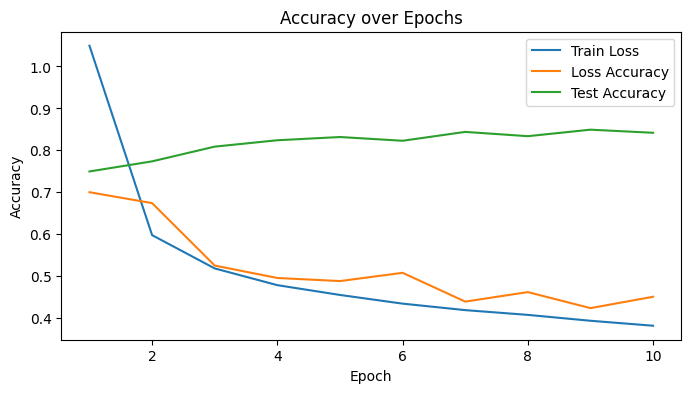

In [ ]:
# Vẽ graph
plt.figure(figsize=(8, 4))
epochs = list(range(1, num_epochs+1))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, accuracy_losses, label='Loss Accuracy')
plt.plot(epochs, test_accs, label='Test Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

## Exercises

### Câu 4: Thiết kế MLP với hai lớp ẩn

MLP với lớp ẩn thứ nhất dùng ReLU, lớp thứ hai dùng tanh:

In [ ]:
class MLPWithTwoHiddenLayers(nn.Module):
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        super(MLPWithTwoHiddenLayers, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.tanh = nn.Tanh()
        self.fc3 = nn.Linear(hidden_size2, output_size)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.tanh(x)
        x = self.fc3(x)
        return x